In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from glob import glob
import os
from matplotlib.colors import ListedColormap
from stdatamodels.jwst import datamodels as dm
from BNBG.Pipeline.BetterBackgroundSubtractStep import getDataWithMask
from BNBG.utils import getSourcePosition
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

In [50]:
class MultiStepObject:
	def __init__(self, folder):
		"""
		Acts as a container for MOS data at Stage 2 (cals), Stage 2 + BNBG (BNBG) and backgrounds (bkg), and Stage 3 (s2d).

		Parameters
		----------
		folder : str
			Path to the folder
		"""
		def get_sorted_files(folder, pattern):
			files = glob(os.path.join(folder, pattern))
			files.sort()
			return files

		cal_list = get_sorted_files(folder, '*nrs1_cal.fits') + get_sorted_files(folder, '*nrs2_cal.fits')
		print(cal_list)
		s2d2_list = get_sorted_files(folder, '*nrs1_s2d.fits') + get_sorted_files(folder, '*nrs2_s2d.fits')
		bkg_list = get_sorted_files(folder, '*nrs1_bkg-BNBG.fits') + get_sorted_files(folder, '*nrs2_bkg-BNBG.fits')
		BNBG_list = get_sorted_files(folder, '*nrs1_cal-BNBG.fits') + get_sorted_files(folder, '*nrs2_cal-BNBG.fits')

		# Assuming lists are of format
		# [001_nrs1, 002_nrs1, 003_nrs1, 001_nrs2, 002_nrs2, 003_nrs2]

		s2d_list = glob(os.path.join(folder, 'Final/*_s2d.fits'))
		print("Opening CALs")
		self.cal_list = [fits.open(_) for _ in cal_list]
		self.wavelength_list = [[_ for _ in cal if _.name == "WAVELENGTH"] for cal in self.cal_list]
		self.cal_list = [[_ for _ in cal if _.name == "SCI"] for cal in self.cal_list]
		self.cal_sources = [[_.header["sourceid"] for _ in cal] for cal in self.cal_list]
		print("Opening S2D2S")
		self.s2d2_list = [dm.open(_) for _ in s2d2_list]
		print("Opening BKGs")
		self.bkg_list = [fits.open(_) for _ in bkg_list]
		self.bkg_list = [[_ for _ in bkg if _.name == "SCI"] for bkg in self.bkg_list]
		print("Opening BNBGs")
		self.BNBG_list = [fits.open(_) for _ in BNBG_list]
		self.BNBG_list = [[_ for _ in BNBG if _.name == "SCI"] for BNBG in self.BNBG_list]
		print("Opening S2Ds")
		self.s2d_list = [fits.open(_) for _ in s2d_list]
		self.s2d_sources = [s2d[1].header["sourceid"] for s2d in self.s2d_list]

	def plot(self, directory):
		for source_id in self.s2d_sources:
			cal_list = self._get_hdus_by_source(source_id, self.cal_list)
			bkg_list = self._get_hdus_by_source(source_id, self.bkg_list)
			bnbg_list = self._get_hdus_by_source(source_id, self.BNBG_list)
			s2d_list = self._get_hdus_by_source(source_id, self.s2d2_list)
			s2d = self.s2d_list[self.s2d_sources.index(source_id)]

			isnrs1 = not all(_ is None for _ in cal_list[:3])
			isnrs2 = not all(_ is None for _ in cal_list[3:])

			if isnrs1:
				cmap = MultiStepObject._binary_to_colormap(use_first_group=False)
				fig = MultiStepObject._plot(cal_list[:3], bkg_list[:3], bnbg_list[:3], s2d_list[:3], s2d, source_id, cmap, "nrs1")
				fig.savefig(f"{directory}{source_id}-nrs1.png")
				plt.show()
			if isnrs2:
				cmap = MultiStepObject._binary_to_colormap(use_first_group=True)
				fig = MultiStepObject._plot(cal_list[3:], bkg_list[3:], bnbg_list[3:], s2d_list[3:], s2d, source_id, cmap, "nrs2")
				fig.savefig(f"{directory}{source_id}-nrs2.png")
				plt.show()


	def _get_hdus_by_source(self, source_id, data_list):
		# hdus, sids are lists, one for each 00N_nrsM file (N=1,2,3, M=1,2)
		# next will return the first element of all hdu that verify sid = source_id
		# if none is found, returns None
		return [
			next((hdu for hdu, sid in zip(hdus, sids) if sid == source_id), None)
			for hdus, sids in zip(data_list, self.cal_sources)
		]

	@staticmethod
	def _binary_to_colormap(use_first_group=True):
		"""
		Create a colormap for 6-bit binary values based on additive color mixing.
		:param use_first_group: If True, use bits 0,2,4; if False, use bits 1,3,5
		"""
		colors = []
		for i in range(64):  # Iterate over all possible 6-bit values
			binary_str = f"{i:06b}"  # Convert number to 6-bit binary string
			if use_first_group:
				r, g, b = int(binary_str[0]), int(binary_str[2]), int(binary_str[4])
			else:
				r, g, b = int(binary_str[1]), int(binary_str[3]), int(binary_str[5])
			colors.append((r, g, b))  # Additive color mixing

		return ListedColormap(colors)

	@staticmethod
	def _plot(cal: list, bkg: list, bnbg: list, s2d2: list, s2d, sourceid, cmap, nrs):
		fig = plt.figure(figsize=(16, 12))
		gs = fig.add_gridspec(6, 4, height_ratios=[4, 4, 1.5, 1.5, 1.5, 12], hspace=0, wspace=0)

		ax_s2d2 = [fig.add_subplot(gs[i+2, 0], xticks=[], yticks=[]) for i in range(3)]
		ax_cal = [fig.add_subplot(gs[i+2, 1], xticks=[], yticks=[]) for i in range(3)]
		ax_bkg = [fig.add_subplot(gs[i+2, 2], xticks=[], yticks=[]) for i in range(3)]
		ax_bnbg = [fig.add_subplot(gs[i+2, 3], xticks=[], yticks=[]) for i in range(3)]
		ax_spec = fig.add_subplot(gs[5, :])
		ax_s2d = fig.add_subplot(gs[1, :], xticks=[], yticks=[])
		ax_con = fig.add_subplot(gs[0, :], xticks=[], yticks=[])

		def plot_cal(ax, imgs, mask=False):
			values = np.array([])
			for i in range(3):
				if imgs[i] is not None:
					values = np.append(values, imgs[i].data.ravel())
			values = values[np.isfinite(values)]
			z1, z2 = (0, 1) if len(values) == 0 else ZScaleInterval().get_limits(values)

			for i in range(3):
				if imgs[i] is not None:
					img = imgs[i].data
					if not mask:
						ax[i].imshow(img, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto", zorder=0)
					else :
						ax[i].imshow(img, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto", zorder=0, cmap="gray")
						# TODO : masking

		plot_cal(ax_cal, cal)
		plot_cal(ax_bkg, bkg)
		plot_cal(ax_bnbg, bnbg)

		for ax, c, i in zip(ax_s2d2, ["r", "g", "b"], range(1,4)):
			ax.add_patch(Rectangle((0, 0), 4, 1, transform=ax.transAxes, color=c, alpha=0.3, zorder=-1, clip_on=False))
			text = ax.text(0.1, 0.3, f"00{i}", color="w", transform=ax.transAxes)
			text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])

		z1, z2 = 1e10, -1e10
		#for i, c in enumerate([(1,0,0,1), (0,1,0,1), (0,0,1,1)]):
			#if s2d2[i] is not None:
				# TODO : plotting
		ax_spec.set_ylabel("Flux")
		ax_spec.set_xlabel(fr"$\lambda$ (µm)")
		dz = (z2 - z1) / 2
		z = (z1 + z2) / 2
		ax_spec.set_ylim(z-dz*1.05,z+dz*1.05)
		ax_spec.grid(True)

		# Set the correct aspect ratio for ax_s2d
		s2d_sci = s2d["SCI"].data
		z1, z2 = ZScaleInterval().get_limits(s2d_sci)
		ax_s2d.imshow(s2d_sci, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto")

		# Set the correct aspect ratio for ax_con
		con_img = s2d["CON"].data[0, :, :]
		ax_con.imshow(con_img, interpolation="none", origin="lower", cmap=cmap, vmin=0, vmax=63, aspect="auto")
		ax_con.set_title(f"{sourceid}-{nrs}")

		for ax in ax_s2d2 + ax_cal + ax_bkg + ax_bnbg + [ax_s2d] + [ax_con]:
			ax.set_axis_off()

		return fig

In [27]:
MSO = MultiStepObject("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA")

['/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00001_nrs1_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00002_nrs1_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00003_nrs1_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00001_nrs2_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00002_nrs2_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00003_nrs2_cal.fits']
Opening CALs
Opening S2D2S
Opening BKGs
Opening BNBGs
Opening S2Ds


In [ ]:
%matplotlib inline
plt.close("all")
MSO.plot("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/SlitAnalysis")

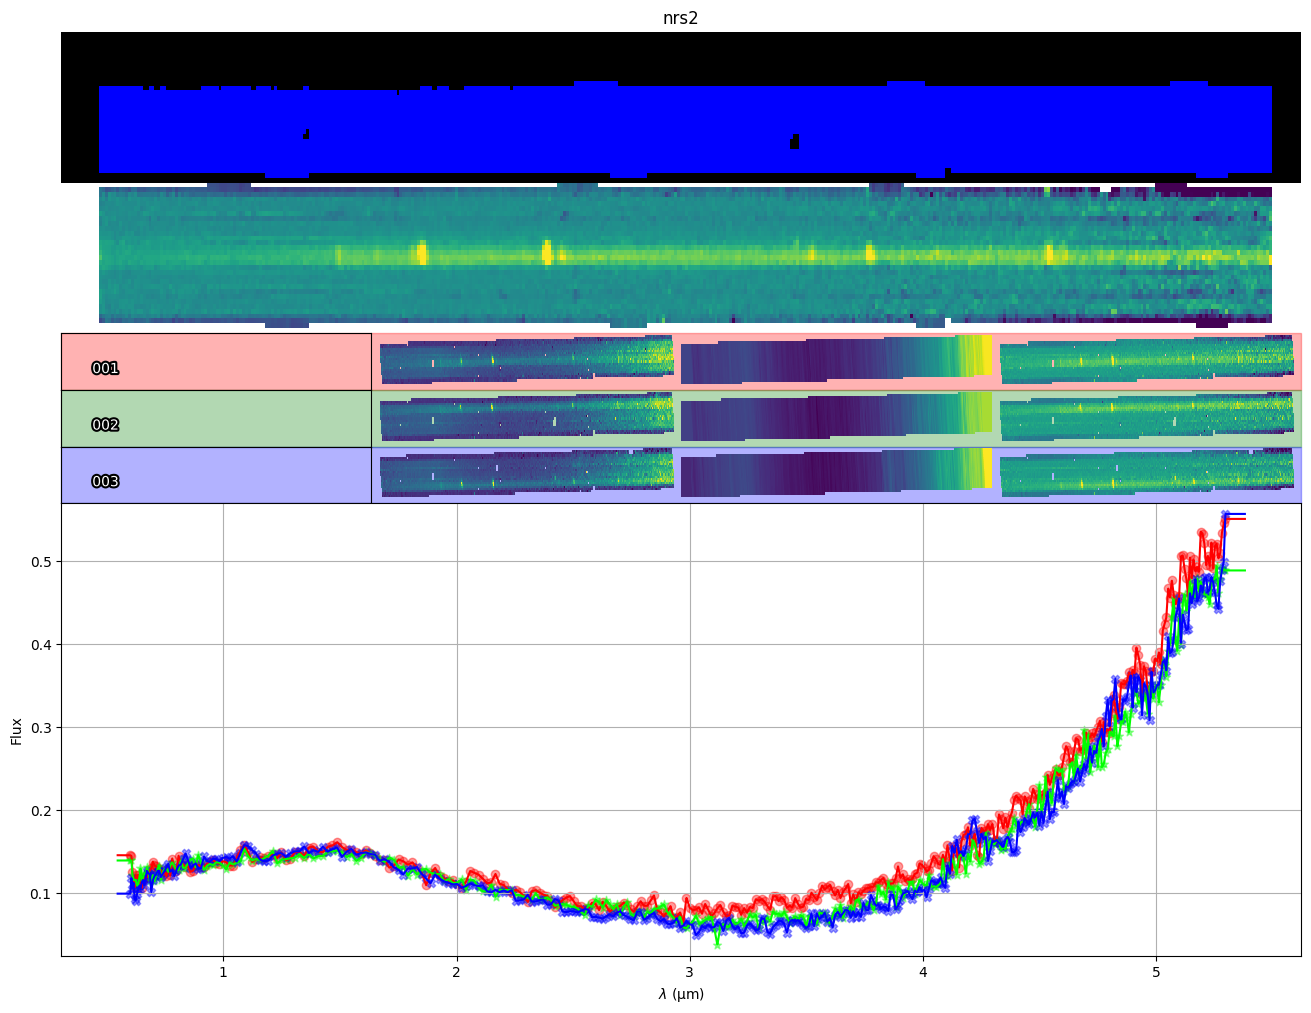

In [51]:
source_id = 4402

cal_list = MSO._get_hdus_by_source(source_id, MSO.cal_list)
bkg_list = MSO._get_hdus_by_source(source_id, MSO.bkg_list)
bnbg_list = MSO._get_hdus_by_source(source_id, MSO.BNBG_list)
wavelength_list = MSO._get_hdus_by_source(source_id, MSO.wavelength_list)
X,Y = MSO._get_1d_data(source_id)
s2d = MSO.s2d_list[MSO.s2d_sources.index(source_id)]

isnrs1 = not all(_ is None for _ in cal_list[:3])
isnrs2 = not all(_ is None for _ in cal_list[3:])

if isnrs1:
	cmap = MultiStepObject._binary_to_colormap(use_first_group=False)
	fig = MultiStepObject._plot(cal_list[:3], bkg_list[:3], bnbg_list[:3], wavelength_list[:3], X[:3], Y[:3], s2d, source_id, cmap, "nrs1")
	plt.show()
if isnrs2:
	cmap = MultiStepObject._binary_to_colormap(use_first_group=True)
	fig = MultiStepObject._plot(cal_list[3:], bkg_list[3:], bnbg_list[3:], wavelength_list[3:], X[3:], Y[3:], s2d, source_id, cmap, "nrs2")
	plt.show()